In [ ]:
# !pip install jiwer

In [2]:
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import os
import re
import json
import time

import random
import numpy as np
from jiwer import wer
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder

from IPython.display import Image

from seq_seq_same import Seq2SeqSame

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 1
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Common parameters

In [3]:
batch_size = 32
split_ratio = 0.8
learning_rate = 0.001

# Loading bAbi

In [5]:
from babi import babiDataset

task = 2

babi = babiDataset(task=task, split_ratio=split_ratio, device=device, seed=SEED)
babi.load(verbose=True)
train_loader, valid_loader, test_loader = babi.create_data_loader(batch_size)

Cannot find dataset in path .data. Downloading dataset...
Training data size:    8000
Validation data size:  2000
Test data size:        1000


# LSTM

In [6]:
# Input dim
input_dim = babi.max_vocab_size
# Number of hidden nodes
hidden_dim = 128
# Number of output nodes
output_dim = babi.max_vocab_size
# Number of LSTMs cells to be stacked
layers = 1
# Boolean value for bidirectioanl or not
bidirectional = True
# Boolean value to use LayerNorm or not
layernorm = True

### Our implementation

In [7]:
from seq_seq_same import LSTMSeq2SeqSame

our = LSTMSeq2SeqSame(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                        layers=layers, bidirectional=bidirectional, layernorm=layernorm).to(device)

print("Our implementation\n{}".format("=" * len("Our implementation")))
print("# of parameters: {}".format(our.count_parameters()))
for name, param in our.named_parameters():
    print("{:<25}: {}".format(name, param.shape))

Our implementation
# of parameters: 180772
lstm.model.0.weights     : torch.Size([164, 512])
lstm.model.0.bias        : torch.Size([512])
lstm.model.0.ln_gates.weight: torch.Size([512])
lstm.model.0.ln_gates.bias: torch.Size([512])
lstm.model.0.ln_candidate.weight: torch.Size([128])
lstm.model.0.ln_candidate.bias: torch.Size([128])
lstm.model_rev.0.weights : torch.Size([164, 512])
lstm.model_rev.0.bias    : torch.Size([512])
lstm.model_rev.0.ln_gates.weight: torch.Size([512])
lstm.model_rev.0.ln_gates.bias: torch.Size([512])
lstm.model_rev.0.ln_candidate.weight: torch.Size([128])
lstm.model_rev.0.ln_candidate.bias: torch.Size([128])
fc.weight                : torch.Size([36, 256])
fc.bias                  : torch.Size([36])


In [0]:
from seq_seq_same import Seq2SeqSame

loss_fn = nn.CrossEntropyLoss()
optimizer_our = torch.optim.Adam(our.parameters(), lr=learning_rate)

task_our = Seq2SeqSame(our, optimizer_our, loss_fn, device)

Beginning training model with 180772 parameters
Files will be saved in: results/Seq2SeqSame/lstm/


Epoch #1: Average loss is 0.6889838197976351
Epoch #1: Validation wer is 1.0
Time taken for epoch: 362.728933095932s


Epoch #2: Average loss is 0.024043725583702324
Time taken for epoch: 323.4875338077545s


Epoch #3: Average loss is 0.01554832249879837
Time taken for epoch: 320.94738841056824s


Epoch #4: Average loss is 0.013122570898383855
Time taken for epoch: 320.46919107437134s


Epoch #5: Average loss is 0.012285146430134774
Epoch #5: Validation wer is 0.6266422750706802
Time taken for epoch: 346.5477411746979s


Epoch #6: Average loss is 0.011544895898550749
Time taken for epoch: 321.766952753067s


Epoch #7: Average loss is 0.010785969886928797
Time taken for epoch: 324.44186425209045s


Epoch #8: Average loss is 0.010665000109001994
Time taken for epoch: 320.0043954849243s


Epoch #9: Average loss is 0.009965423621237278
Time taken for epoch: 318.1082262992859s


Epoch #10: Av

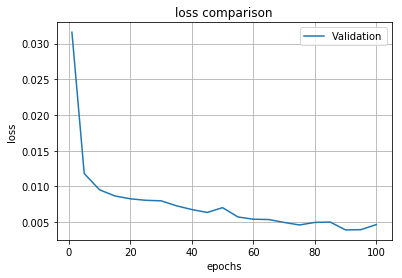

In [7]:
our, our_stats = task_our.train(epochs=100, train_loader=train_loader, valid_loader=valid_loader, 
                                out_dir='results/Seq2SeqSame/lstm/', freq=5, vocab=babi.vocab, 
                                wer_dict=babi.wer_dict, train_eval=False)

In [14]:
our_wer, _ = task_our.evaluate(test_loader, babi.vocab, babi.wer_dict, verbose=True)
print(our_wer)

Confusion Matrix: 
 [[233  43  78  57  32  67]
 [ 61 238  38  51  67  52]
 [ 55  48 213  81  50  34]
 [ 44  57  64 245  95  50]
 [ 70  50  41  47 206  56]
 [ 38  34  45  46  68 246]]

Classification Report: 
               precision    recall  f1-score   support

           7       0.47      0.46      0.46       510
          10       0.51      0.47      0.49       507
          16       0.44      0.44      0.44       481
          18       0.46      0.44      0.45       555
          21       0.40      0.44      0.42       470
          22       0.49      0.52      0.50       477

    accuracy                           0.46      3000
   macro avg       0.46      0.46      0.46      3000
weighted avg       0.46      0.46      0.46      3000

0.5396666666666666


### Sample output

In [0]:
for text, label in test_loader:
    pass
h = torch.zeros(2 * task_our.model.layers, label.shape[0], task_our.model.hidden_dim).to(device)
c = torch.zeros(2 * task_our.model.layers, label.shape[0], task_our.model.hidden_dim).to(device)
o = task_our.model(text.transpose(0, 1).to(device), h, c)
for i in range(text.shape[0]):
    s1 = ' '.join(babi.vocab[torch.argmax(text, 2)[i].numpy()])
    s1 = s1.replace('_', '\r')
    s2 = ' '.join(babi.vocab[torch.argmax(o.transpose(1,0), 2)[i].cpu().numpy()])
    s2 = s2.replace('_ _ _', '')
    s2 = s2.replace('_ _', '')
    s2 = s2.replace('_', '')
    print(s1)
    print(s2)
    print("-" * 100)

 Mary moved to the hallway . Sandra went to the garden . Where is Sandra ? Mary went back to the kitchen . Sandra journeyed to the kitchen . Where is Sandra ? Daniel went back to the garden . John went to the garden . Where is John ?
                 garden       kitchen       garden
----------------------------------------------------------------------------------------------------
 Mary moved to the hallway . Sandra went to the garden . Where is Sandra ? Mary went back to the kitchen . Sandra journeyed to the kitchen . Where is Sandra ? Daniel went back to the garden . John went to the garden . Where is John ? Mary travelled to the office . Sandra went to the bathroom . Where is Daniel ?
            garden       kitchen       garden      garden
----------------------------------------------------------------------------------------------------
 Mary moved to the hallway . Sandra went to the garden . Where is Sandra ? Mary went back to the kitchen . Sandra journeyed to the kitchen . W

***

# Transformer

## Our implementation

In [9]:
from seq_seq_same import TransformerSeq2SeqSame

# create model

# 174k
model = TransformerSeq2SeqSame(in_dim=babi.max_vocab_size, out_dim=babi.max_vocab_size, N=1, heads=4, 
                               model_dim=128, key_dim=16, value_dim=16, ff_dim=512, 
                               batch_first=False)

model = model.to(device)
print(model.count_parameters())

174692


In [0]:
from seq_seq_same import Seq2SeqSame
from transformer import NoamOpt

loss_fn = nn.CrossEntropyLoss()

optimizer = NoamOpt(model.model_dim, 1, 2000,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

task = Seq2SeqSame(model, optimizer, loss_fn, device)

Beginning training model with 174692 parameters
Files will be saved in: results/Seq2SeqSame/transformer/


Epoch #1: Average loss is 1.1409985744208098
Epoch #1: Train WER is 1.0
Epoch #1: Validation WER is 1.0
Time taken for epoch: 29.358094453811646s


Epoch #2: Average loss is 0.02251294704899192
Time taken for epoch: 17.852921962738037s


Epoch #3: Average loss is 0.012525254983454942
Time taken for epoch: 17.882906198501587s


Epoch #4: Average loss is 0.012241618771106005
Time taken for epoch: 17.883750438690186s


Epoch #5: Average loss is 0.011348053380846978
Epoch #5: Train WER is 0.6385959061158127
Epoch #5: Validation WER is 0.6479294861134209
Time taken for epoch: 29.28817892074585s


Epoch #6: Average loss is 0.010234462795779109
Time taken for epoch: 18.393473863601685s


Epoch #7: Average loss is 0.009782615078613163
Time taken for epoch: 18.420594692230225s


Epoch #8: Average loss is 0.009607435328885913
Time taken for epoch: 18.463473081588745s


Epoch #9: Average los

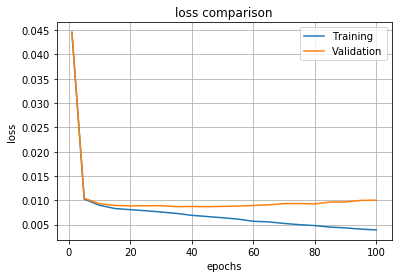

In [7]:
model, stats = task.train(epochs=100, train_loader=train_loader, valid_loader=valid_loader, 
                                            out_dir='results/Seq2SeqSame/transformer/', freq=5, vocab=babi.vocab, 
                                            wer_dict=babi.wer_dict)

### Evaluate

In [8]:
transformer_wer, _ = task.evaluate(test_loader, babi.vocab, babi.wer_dict, verbose=True)
print(transformer_wer)

Confusion Matrix: 
 [[  0   0   0   0   0   0   0]
 [  4 129  28  35 149 128  37]
 [  9  68  82  38 148  99  63]
 [  5  77  17  69 133 133  47]
 [  4  68  34  19 298  86  46]
 [  3  51  28  37 167 147  37]
 [  3  34  29  36 192  94  89]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           7       0.30      0.25      0.28       510
          10       0.38      0.16      0.23       507
          16       0.29      0.14      0.19       481
          18       0.27      0.54      0.36       555
          21       0.21      0.31      0.25       470
          22       0.28      0.19      0.22       477

    accuracy                           0.27      3000
   macro avg       0.25      0.23      0.22      3000
weighted avg       0.29      0.27      0.26      3000

0.7286666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [9]:
task.model.load('results/Seq2SeqSame/transformer/model_epoch_25.pkl')
transformer_wer, _ = task.evaluate(test_loader, babi.vocab, babi.wer_dict, verbose=True)
print(transformer_wer)

Confusion Matrix: 
 [[184  60  22 109  99  36]
 [ 83 151  12 103 104  54]
 [106  45  50 101 133  46]
 [ 96  44  12 248 107  48]
 [ 85  44  11  97 191  42]
 [ 64  49  25 137 105  97]]

Classification Report: 
               precision    recall  f1-score   support

           7       0.30      0.36      0.33       510
          10       0.38      0.30      0.34       507
          16       0.38      0.10      0.16       481
          18       0.31      0.45      0.37       555
          21       0.26      0.41      0.32       470
          22       0.30      0.20      0.24       477

    accuracy                           0.31      3000
   macro avg       0.32      0.30      0.29      3000
weighted avg       0.32      0.31      0.29      3000

0.693
